In [16]:
# Imports
import cv2
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
import json
import shutil
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from digit_train_dataset import digit_train_dataset
from digit_test_dataset import digit_test_dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 20

train_transforms = transforms.Compose([transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.ToTensor()])


# Load Data
train_dataset = ImageFolder(root = './dataset_images_keras/train',
                             transform = train_transforms)
test_dataset = ImageFolder(root = './dataset_images_keras/test/',
                             transform = test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Label: 0


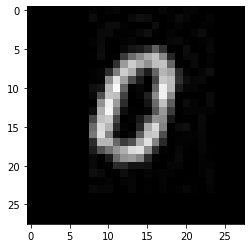

In [19]:
def show_image(image, label, dataset):
    print(f"Label: {label}") 
    plt.imshow(image.permute(1,2,0))
    plt.show()

show_image(*train_dataset[10], train_dataset)

In [20]:
def save_ckp(state, is_best, checkpoint_path, best_model_path, epoch, model_name):
    """
    state: checkpoint to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    #print(f_path)
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, model_name + "_epoch_" + str(epoch) + "_model.pt")
    
    # if it is a best model, min validation loss
    #if is_best:
    #    best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
    #    shutil.copyfile(f_path, best_fpath)

In [21]:
checkpoint_path = "./Users/tobiasschulz/Documents/GitHub/digit_dataset/Classifier/saved_checkpoints/resnet/"
best_model_path = "./Users/tobiasschulz/Documents/GitHub/digit_dataset/Classifier/saved_best_model/resnet/"

In [22]:
def train(start_epochs, n_epochs, valid_loss_min_input, checkpoint_path, best_model_path, criterion, optimizer):
    """
    Keyword arguments:
    start_epochs -- the real part (default 0.0)
    n_epochs -- the imaginary part (default 0.0)
    valid_loss_min_input
    loaders
    model
    optimizer
    criterion
    use_cuda
    checkpoint_path
    best_model_path
    
    returns trained model
    """
    model.to(device)

    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 
    
    num_correct = 0
    num_samples = 0
    train_losses, valid_losses = [], []
    
    model_name = model.__class__.__name__
    print(model_name)
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            # move to GPU
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, targets)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(test_loader):
            # move to GPU
            x = x.to(device=device)
            y = y.to(device=device)
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(x)
            # calculate the batch loss
            loss = criterion(output, y)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            _, predictions = output.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
              
        
        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        
        # save checkpoint
    
        save_ckp(checkpoint, False, checkpoint_path, best_model_path, epoch+1, model_name)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path, epoch+1, model_name)
            valid_loss_min = valid_loss
    
    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    
    documentation[model_name] = float(num_correct)/float(num_samples)*100
    
    # return trained model
    return model 

In [23]:
class CNN_own(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
# Loss and optimizer
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

In [24]:
model = Net()
model_name = model.__class__.__name__
documentation = {model_name: 0}

In [25]:
# Model
model = torchvision.models.googlenet(pretrained=True)
model_name = model.__class__.__name__
documentation = {model_name: 0}

In [26]:
# CNN OWN training
trained_model = train(0, 20, 0.005, checkpoint_path, best_model_path, criterion, optimizer)

NameError: name 'criterion' is not defined

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
with open("documentation.json", "w") as outfile: 
    json.dump(documentation, outfile) 

In [ ]:
with open("sample_file.json", "r+") as file:
    data = json.load(file)
    data.update(documentation)
    file.seek(0)
    json.dump(data, file)

## Prediction with CNN_own

In [ ]:
test_transforms = transforms.Compose([transforms.ToTensor()])

In [ ]:
predict_dataset = ImageFolder(root = './dataset_images_keras/test/',
                             transform = test_transforms)

In [ ]:
model.eval()

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
img67 = cv2.imread("/Users/tobiasschulz/Documents/GitHub/ai-fall-exercises/M6/07. Template matching, corners and Haar cascades/img/export/67.png")
plt.imshow(img67)

In [ ]:
label = predict_image(img67)
label

In [ ]:
folder_path = "/Users/tobiasschulz/Documents/GitHub/ai-fall-exercises/M6/07. Template matching, corners and Haar cascades/img/export/"
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
images = [ x for x in images if ".DS_Store" not in x ]

In [ ]:
predictions = {}
for image in images:
    image_name = image.split("/")[-1:][0].split('.')[0]
    img = cv2.imread(image)
    label = predict_image(img)
    predictions[image_name] = label

In [ ]:
predictions